# IllRun

#### Explanation of what is the project

This project is used as example of use of statsmodels sklean on supervised learning to conclude the for-credit option for **Introduction to Machine Learning: Supervised Learning** (CSCA 5622-100).

#### Goal of the project
As an amateur runner, I have sometimes dificulties to predict if I'll run or not next day. One of the helpers that I can have is considering the previous data of my runnings to get more information about next runnings. The main idea is create a model and an application that will predict if I'll be running tomorrow or not and what distance. 

#### Data source
The data will come exclusively from an cvs exported throught the app [RungGap](https://www.rungap.com/) from my runnings on last year. This data is a tabulated data with 23 columns.

#### Data Description

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 
%matplotlib inline 
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

#import file
df = pd.read_csv("rungap-export.csv")
print(df.describe())

       activity id   duration(s)  elapsed time(s)   distance(m)  \
count   763.000000    763.000000       763.000000    763.000000   
mean    284.625164   1864.966723      1935.944377   3513.669567   
std     423.462327   1144.930242      1638.200015   2820.018264   
min     100.000000      0.000000         0.000000      0.000000   
25%     100.000000   1363.415000      1369.025000   1739.825000   
50%     106.000000   1803.290000      1819.930000   3333.730000   
75%     200.000000   2160.415000      2183.590000   4687.545000   
max    1414.000000  17152.000000     31229.640000  21157.370000   

       calories(kcal)         steps  avg speed(m/s)  max speed(m/s)  \
count      763.000000    763.000000      763.000000      763.000000   
mean       340.604194   3824.339450        1.689567        2.660904   
std        229.185653   3112.307929        0.948915        1.485587   
min          0.000000      0.000000        0.000000        0.000000   
25%        181.000000   1939.000000      

In [2]:
print(f"Data info:")
df.info()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   local time        763 non-null    object 
 1   activity          763 non-null    object 
 2   activity id       763 non-null    int64  
 3   source activity   763 non-null    object 
 4   duration(s)       763 non-null    float64
 5   elapsed time(s)   763 non-null    float64
 6   distance(m)       763 non-null    float64
 7   calories(kcal)    763 non-null    int64  
 8   steps             763 non-null    int64  
 9   avg speed(m/s)    763 non-null    float64
 10  max speed(m/s)    763 non-null    float64
 11  avg heartrate     763 non-null    int64  
 12  max heartrate     763 non-null    int64  
 13  avg cadence       763 non-null    int64  
 14  max cadence       763 non-null    int64  
 15  avg power         763 non-null    int64  
 16  max power         763 non-null   

### Data Cleaning

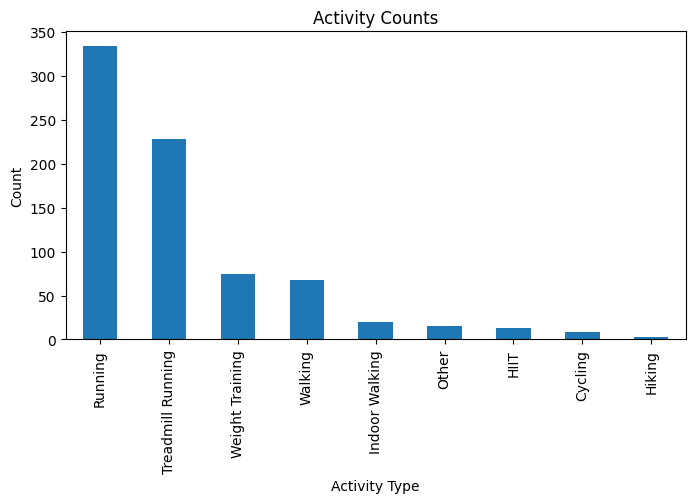

In [3]:
#let's check what kind of activities do we have on the file
activity_counts = df['activity'].value_counts()
plt.figure(figsize=(8,4))
activity_counts.plot(kind='bar')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.title('Activity Counts')
plt.show()

In [4]:
# other activities exported, let's filter only by running, not need other activities
# lets considere Running and Treadmill Running as running:
df = df[df['activity'].str.contains('Running', case=False, na=False)]

# Keep only possible relevant columns
#df = df[['local time', 'duration(s)', 'distance(m)', 'avg heartrate']]
#I'll  keep only local time and distance(m) for now.. in the future I can predict duration and heartrate
df = df[['local time', 'distance(m)']]

### Exploratory data analysis (EDA)

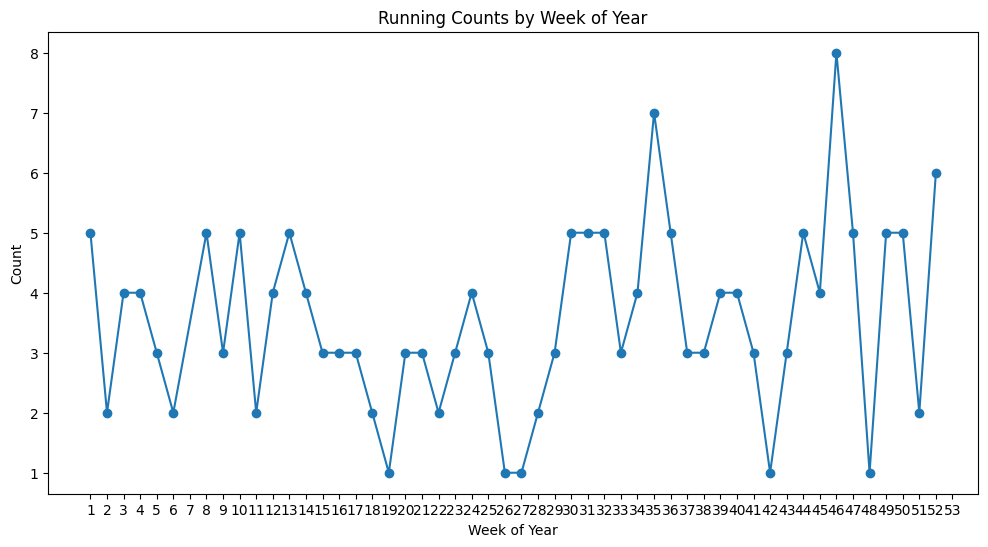

In [5]:
# to make sure the date is balanced, its better to filter by date (let's consider last year)
df['local time'] = pd.to_datetime(df['local time'])

df = df[(df['local time'] >  pd.to_datetime('2024-08-24')) & (df['local time'] < pd.to_datetime('2025-08-26'))]

#lets plot a graph of running by week of the year
df['week_of_year'] = df['local time'].dt.isocalendar().week
weekly_counts = df['week_of_year'].value_counts().sort_index()
plt.figure(figsize=(12,6))
weekly_counts.plot(kind='line', marker='o')
plt.xlabel('Week of Year')
plt.ylabel('Count')
plt.title('Running Counts by Week of Year')
plt.xticks(ticks=range(1, 54), rotation=0)
plt.show()


ok, considering the week of the year, I can predict if I'll be running or not tomorow, but first
the current data is not balanced, because I only have running=true on it.. I need to add running=false for days that don't have running

In [6]:
# Add days that don't have running to make sure data is balanced

# First we need to normalize the hour
df['local time'] = pd.to_datetime(df['local time']).dt.normalize()

# Aggregate so each date is unique (sum distance and duration and mean heartrate)
df_allDays = df.groupby('local time').agg({
    #'duration(s)': 'sum',
    'distance(m)': 'sum' #,
    #'avg heartrate': 'mean'
}).reset_index()

# add not runned days
all_days = pd.date_range(start=df_allDays['local time'].min(), end=df_allDays['local time'].max(), freq='D')
df_allDays = df_allDays.set_index('local time').reindex(all_days).rename_axis('local time').reset_index()
df_allDays['distance(m)'] = df_allDays['distance(m)'].fillna(0)
#df_allDays['duration(s)'] = df_allDays['duration(s)'].fillna(0)

df=df_allDays
df.tail()

,local time,distance(m)
362,2025-08-21,5011.15
363,2025-08-22,0.00
364,2025-08-23,16767.08
365,2025-08-24,0.00
366,2025-08-25,5749.90


Only the day maybe will be a not precise way to predict if I will run or not.. let's add couple features on the data:
* Runned (if distance<> 0 , runned=1)
* LastDayRun (Distance in days from last day runned)
* Day of week, it can be a strong predictor of my runnings, lets see
* week of the year, seasons can have some interference if I'll be running or not
* RestDayBeforeRun... LastDayRun shows 0 if I run today, so, a better predictor will be restDayBeforeRun

In [7]:
last_run_date = df['local time'].where((df['distance(m)'] != 0).astype(int) == 1)
last_run_date = last_run_date.ffill()

# Calculate the difference in days
df['LastDayRun'] = (df['local time'] - last_run_date).dt.days

#add weekday
df['weekday'] = df['local time'].dt.weekday

#addWekOfYear
df['week_of_year'] = df['local time'].dt.isocalendar().week
pd.set_option('display.max_rows', None)

#add is_weekend
df['is_weekend'] = df['weekday'].isin([5, 6])

df['RestDaysBeforeRun'] = df['LastDayRun'].shift(1)
df['RestDaysBeforeRun'] = df['RestDaysBeforeRun'].fillna(0)
df.head()

,local time,distance(m),LastDayRun,weekday,week_of_year,is_weekend,RestDaysBeforeRun
0,2024-08-24,3393.80,0,5,34,True,0.0
1,2024-08-25,0.00,1,6,34,True,0.0
2,2024-08-26,4260.50,0,0,35,False,1.0
3,2024-08-27,0.00,1,1,35,False,0.0
4,2024-08-28,9386.72,0,2,35,False,1.0


In [8]:
df.corr()

,local time,distance(m),LastDayRun,weekday,week_of_year,is_weekend,RestDaysBeforeRun
local time,1.000000,-0.041658,-0.008778,-0.000064,-0.355676,-0.003008,-0.002186
distance(m),-0.041658,1.000000,-0.504802,-0.070272,0.121031,-0.108376,0.088872
LastDayRun,-0.008778,-0.504802,1.000000,0.177644,-0.053725,0.168260,0.560304
weekday,-0.000064,-0.070272,0.177644,1.000000,0.001077,0.792177,0.052821
week_of_year,-0.355676,0.121031,-0.053725,0.001077,1.000000,0.003300,-0.050629
is_weekend,-0.003008,-0.108376,0.168260,0.792177,0.003300,1.000000,0.088761
RestDaysBeforeRun,-0.002186,0.088872,0.560304,0.052821,-0.050629,0.088761,1.000000


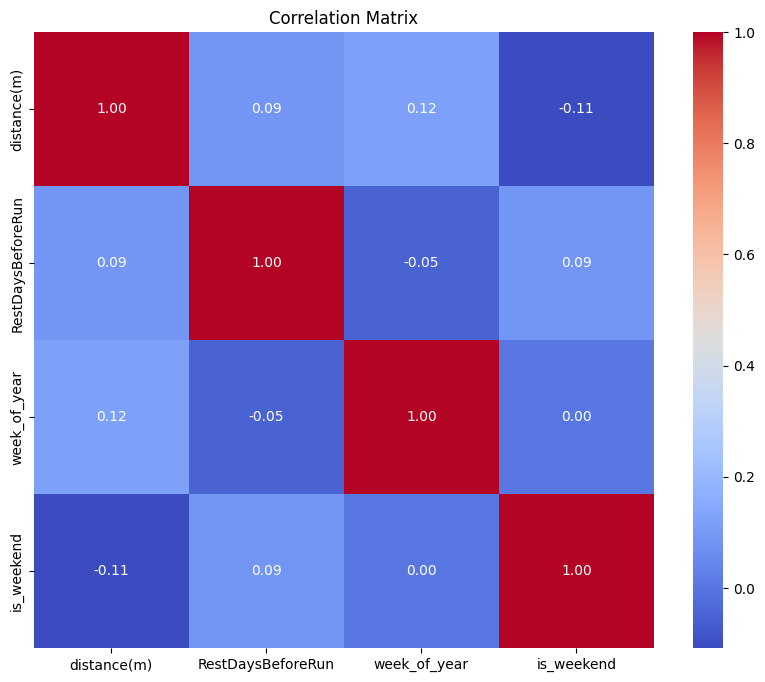

In [9]:
corr_matrix = df[['distance(m)', 'RestDaysBeforeRun',  'week_of_year', 'is_weekend']].corr()

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### Correlation matrix:
 Conclusions:
The correlation matrix shows linear relationships, but my running habits are more complex and non-linear, however we can conclude:
- The weak positive correlation between RestDaysBeforeRun and distance shows that I run longer after more rest.
- The positive correlation between week_of_year and distance shows that I run more by the end of the year than by the begining
- The weekday patter is minimal due to low correlation (-0.07) between weekday and distance(m). So there is not one strong weekday. But there is difference between week and weekend days. (I run more on weekdays)


#### Statistical testing

Correlation between RestDaysBeforeRun and distance(m):
Correlation Coefficient: 0.09
P-value: 0.0891


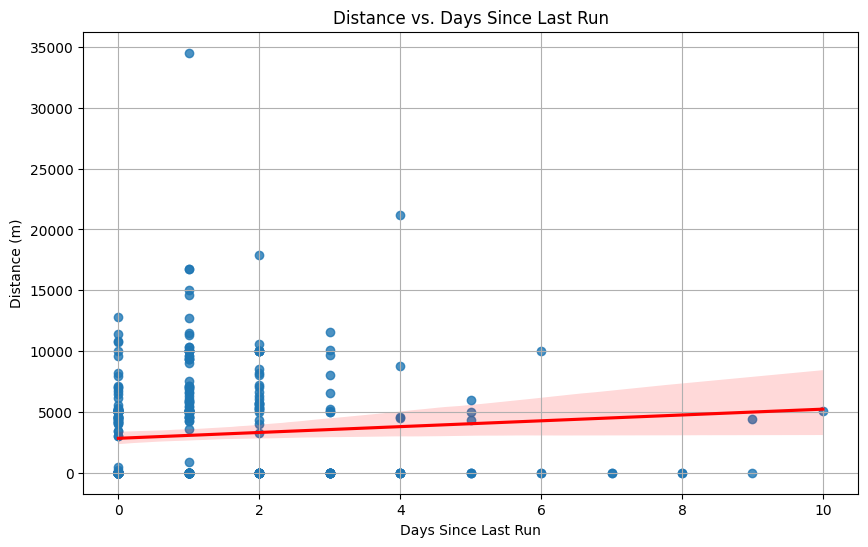

In [10]:
#let's do a statistical test to see if the correlation between LastDayRun and distance(m) is significant
col1 = df['RestDaysBeforeRun']
col2 = df['distance(m)']
correlation_coefficient, p_value = stats.pearsonr(col1, col2)

print(f"Correlation between RestDaysBeforeRun and distance(m):")
print(f"Correlation Coefficient: {correlation_coefficient:.2f}")
print(f"P-value: {p_value:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='RestDaysBeforeRun', y='distance(m)', data=df, line_kws={"color": "red"})
plt.title('Distance vs. Days Since Last Run')
plt.xlabel('Days Since Last Run')
plt.ylabel('Distance (m)')
plt.grid(True)
plt.show()



It confirms that my trainning pattern is not straight-line... Its more complex and a simple linear model will not be a good fit for it.

T-test between weekend and weekday running distances:
T-statistic: -2.08
P-value: 0.0380


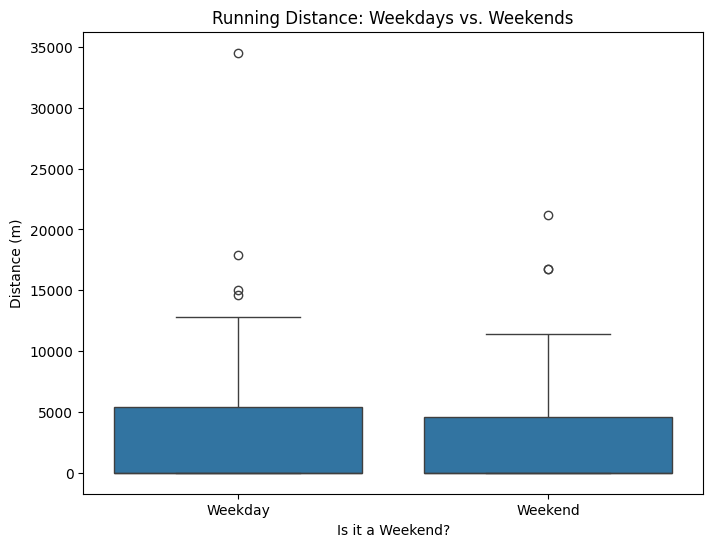

In [11]:
# also, let's do a T-test to see if there's a significant difference in running distance between weekends and weekdays
df['is_weekend'] = df['weekday'].isin([5, 6])
weekend_distances = df[df['is_weekend'] == True]['distance(m)']
weekday_distances = df[df['is_weekend'] == False]['distance(m)']
t_statistic, p_value = stats.ttest_ind(weekend_distances, weekday_distances)
print(f"T-test between weekend and weekday running distances:")
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.4f}")


# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_weekend', y='distance(m)', data=df)
plt.title('Running Distance: Weekdays vs. Weekends')
plt.xlabel('Is it a Weekend?')
plt.ylabel('Distance (m)')
plt.xticks([0, 1], ['Weekday', 'Weekend']) # Make labels more readable
plt.show()

The distance runned on weekends are significant different than the distances on the weekdays. I run ore on weekdays.

### Model

In [12]:
# split data into train and test
features = ['RestDaysBeforeRun', 'week_of_year', 'is_weekend']
target = 'distance(m)'

X = df[features]
y = df[target]

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#### RandomForest Model
On the EDA it was clear that a linear model will not fit on it. I'll start testing a RandomForest to se how it behaves.

In [13]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_test_predictions = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_test_predictions)

In [14]:
print(f"Random Forest Model")
print(f"Mean Absolute Error on Test Set: {rf_mae:.2f} meters")

Random Forest Model
Mean Absolute Error on Test Set: 3447.05 meters


Off by 3.45 km is not a good predictor, let's try to improve this model using a GridSearchCV

In [15]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)

# Fit it to your training data
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_
print(best_rf_model)

# and lets check the metric for the best model:
rf_test_predictions_best = best_rf_model.predict(X_test)
rf_mae_best = mean_absolute_error(y_test, rf_test_predictions_best)
print(f"Mean Absolute Error on Test Set (on best predictor): {rf_mae:.2f} meters")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
RandomForestRegressor(max_depth=5, min_samples_leaf=4, n_estimators=300,
                      random_state=42)
Mean Absolute Error on Test Set (on best predictor): 3447.05 meters


OK, 100 or 300 estimators don't bring any difference, let's keep our RandomForestModel: rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#### Testing a seccond model

let's try with XGBoost model

In [16]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

test_predictions = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, test_predictions)

print(f"XGBoost Model")
print(f"Mean Absolute Error on Test Set: {mae:.2f} meters")

XGBoost Model
Mean Absolute Error on Test Set: 3618.94 meters


XGBoost is worst than RandomForest.. lets try early stopping

In [17]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,          
    learning_rate=0.05,
    early_stopping_rounds=10,   
    random_state=42
)

xgb_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=False 
)

print(xgb_model)
print(f"Done, find best xgb model, trees: {xgb_model.best_iteration}")

test_predictions = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, test_predictions)
print(f"MAE: {mae:.2f} meters")


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)
Done, find best xgb model, trees: 7
MAE: 3338.63 meters


I think we are done... even there is a couple of meters on mae, this xgb model is the best from the two selected. Let's get some visualization from it

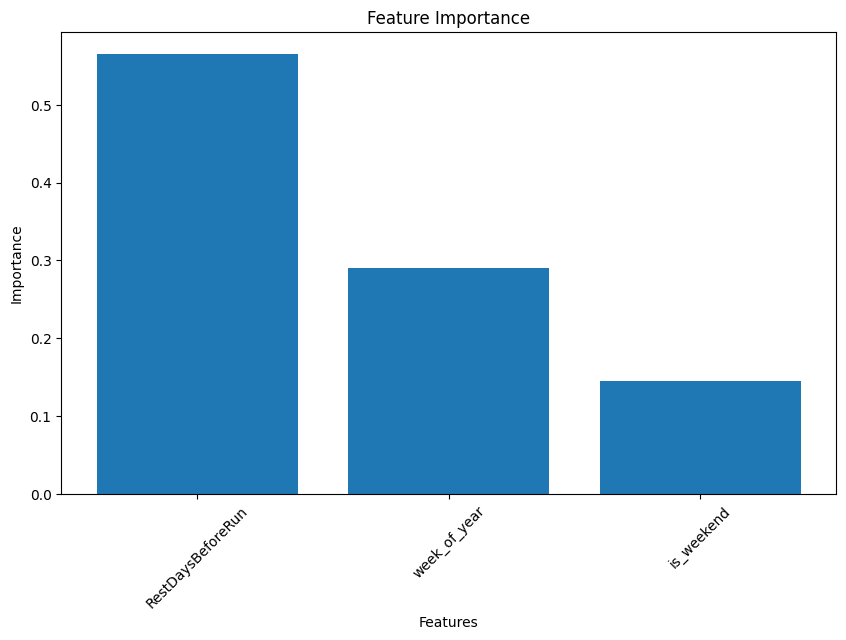

In [18]:
#let's check the feature importance:

importances = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()


**Conclusion:** None of the models tested are really good to predict my runnings, however XGBoost it's predicting if I'll be running or not based on my last year of running. 

RandomForest and XGBoost are similar. But as XGBoost perfomed better a demo app will be created using it. And as we can see, the RestDaysBeforeRun is the most important feature to be used on the prediction.

Nexts steps is adding the weather, getting the historic weather from the day and the forecast for tomorrow, this variable will probably bring much more useful insights.

One step further could be predict the the duration of runnings and heart hate average.

A demo of the project will be running here:


[https://tiubak.pythonanywhere.com/]

This notebook was created with unlimited help of search on the web (**google** engine) and **Gemini Pro 2.5** to answer specific questions about programming and how to use the libraries.